In [15]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [11]:
# 创建DFN模型
model = pybamm.lithium_ion.DFN()

# 创建实验
experiment = pybamm.Experiment(
    ["Rest for 901 s",
        "Discharge at 0.96 A for 147 s",
        "Rest for 361 s",
        "Discharge at 0.96 A for 134 s"
    ]
)

# 设置参数
param = pybamm.ParameterValues("OKane2022")

# 创建仿真对象
solver = pybamm.CasadiSolver(mode="safe")
simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)

# 运行仿真
solution = simulation.solve(calc_esoh=False)

# 获取结果
time = solution["Time [s]"].entries
voltage = solution["Terminal voltage [V]"].entries

# 插值以获得每秒的电压值
# 确保时间从0秒开始（如果不是，需要调整time数据）
if time[0] != 0:
    time = np.insert(time, 0, 0)
    voltage = np.insert(voltage, 0, voltage[0])

time_new = np.arange(0, int(time[-1]) + 1)  # 创建一个从0到最后时间的每秒数组
interp_func = interp1d(time, voltage, kind='linear', fill_value="extrapolate")
voltage_new = interp_func(time_new)  # 对每秒进行插值

# 将结果保存到DataFrame中
df = pd.DataFrame({
    "Time [s]": time_new,
    "Voltage [V]": voltage_new
})

# 保存DataFrame到CSV文件
df.to_csv("interpolated_voltage.csv", index=False)

In [13]:
# 将结果保存到DataFrame中
df = pd.DataFrame({
    "Time [s]": time,
    "Voltage [V]": voltage
})

# 保存DataFrame到CSV文件
df.to_csv("origin_voltage.csv", index=False)

In [17]:
df_ex = pd.read_csv('data/data_ocv_ex.csv')
df_ex_6115 = df_ex.head(1544)
voltage_ex = df_ex_6115['Voltage[V]']

In [18]:
# Calculating MSE
mse = mean_squared_error(voltage_ex, voltage_new)
print(f'MSE: {mse}')

MSE: 0.00016832278556143233


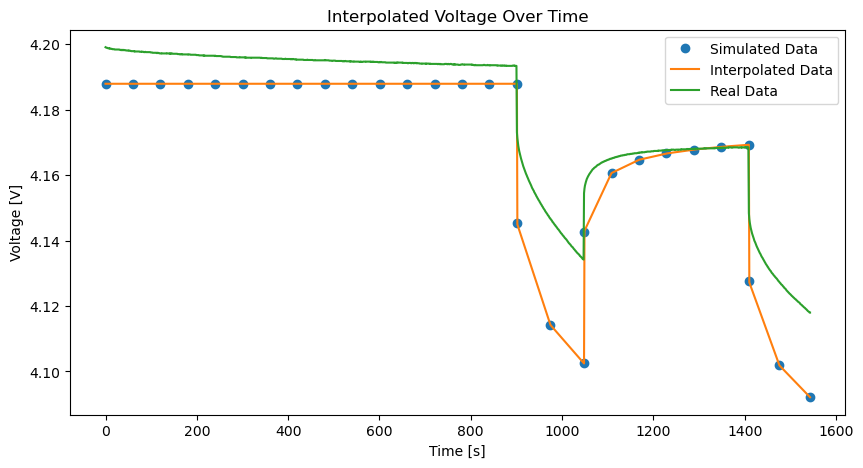

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(time, voltage, 'o', label='Simulated Data')
plt.plot(time_new, voltage_new, '-', label='Interpolated Data')
plt.plot(time_new, voltage_ex, '-', label='Real Data')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.title('Interpolated Voltage Over Time')
plt.legend()
plt.show()